In [1]:
import sys
spath = '../'
sys.path.insert(0,spath)
from scripts.models import get_rttm_segments_features, sort_segments_by_speakers, Ivector
from scripts.notebook import \
get_best_speakers, \
limit_segments_speakers_names, \
limit_segments_speakers_length, \
balance_speakers_segments_length, \
get_speakers_segments_indexes, \
get_speakers_models, \
get_speakers_permutations, \
get_speakers_weights

import itertools
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.animation as animation

### Loading data from drive

In [2]:
dimension = 128

dev_a_rttm     = '../augmented/callhome/callhome1/augmented_0/1.5_0.5_0.5/' + str(dimension) + '/ref.rttm'
dev_a_segments = '../augmented/callhome/callhome1/augmented_0/1.5_0.5_0.5/' + str(dimension) + '/segments'
dev_a_ivectors = '../augmented/callhome/callhome1/augmented_0/1.5_0.5_0.5/' + str(dimension) + '/exp/make_ivectors/ivector.txt'
dev_a_files_segments = get_rttm_segments_features(dev_a_rttm, dev_a_segments, dev_a_ivectors)

dev_b_rttm     = '../augmented/callhome/callhome1/augmented_0/1.0_0.3_0.5/' + str(dimension) + '/ref.rttm'
dev_b_segments = '../augmented/callhome/callhome1/augmented_0/1.0_0.3_0.5/' + str(dimension) + '/segments'
dev_b_ivectors = '../augmented/callhome/callhome1/augmented_0/1.0_0.3_0.5/' + str(dimension) + '/exp/make_ivectors/ivector.txt'
dev_b_files_segments = get_rttm_segments_features(dev_b_rttm, dev_b_segments, dev_b_ivectors)

dev_c_rttm     = '../augmented/callhome/callhome1/augmented_0/0.5_0.1_0.5/' + str(dimension) + '/ref.rttm'
dev_c_segments = '../augmented/callhome/callhome1/augmented_0/0.5_0.1_0.5/' + str(dimension) + '/segments'
dev_c_ivectors = '../augmented/callhome/callhome1/augmented_0/0.5_0.1_0.5/' + str(dimension) + '/exp/make_ivectors/ivector.txt'
dev_c_files_segments = get_rttm_segments_features(dev_c_rttm, dev_c_segments, dev_c_ivectors)

### Filtering data

In [3]:
# Getting the two first speakers of each file
dev_a_files_speakers = get_best_speakers(dev_a_files_segments, 2)
dev_b_files_speakers = get_best_speakers(dev_b_files_segments, 2)
dev_c_files_speakers = get_best_speakers(dev_c_files_segments, 2)

# Removing single-speaker files
'''delete = [file_id for file_id, speakers_names in dev_a_files_speakers.items() if len(speakers_names) < 2]
for file_id in delete:
    del dev_a_files_speakers[file_id]
delete = [file_id for file_id, speakers_names in dev_b_files_speakers.items() if len(speakers_names) < 2]
for file_id in delete:
    del dev_b_files_speakers[file_id]
delete = [file_id for file_id, speakers_names in dev_c_files_speakers.items() if len(speakers_names) < 2]
for file_id in delete:
    del dev_c_files_speakers[file_id]'''

# Filtering segments that only contain speakers from the list
dev_a_files_segments_lim = limit_segments_speakers_names(dev_a_files_segments, dev_a_files_speakers, log = True)
dev_b_files_segments_lim = limit_segments_speakers_names(dev_b_files_segments, dev_b_files_speakers, log = True)
dev_c_files_segments_lim = limit_segments_speakers_names(dev_c_files_segments, dev_c_files_speakers, log = True)

# Filtering segments thath only contain one speaker
dev_a_files_segments_lim = limit_segments_speakers_length(dev_a_files_segments_lim, 1, log = True)
dev_b_files_segments_lim = limit_segments_speakers_length(dev_b_files_segments_lim, 1, log = True)
dev_c_files_segments_lim = limit_segments_speakers_length(dev_c_files_segments_lim, 1, log = True)

Kept 29403 of 40598: 0.7242474998768412
Kept 38643 of 53526: 0.7219482120838471
Kept 61654 of 85518: 0.7209476367548352
Kept 20079 of 29403: 0.6828895010713193
Kept 26371 of 38643: 0.6824263126568848
Kept 42154 of 61654: 0.6837188179193564


In [4]:
from torch.utils.data import Dataset

class Files_dataset(Dataset):
    def __init__(self,
                 files_segments,
                 models_generation_lengths = [3],
                 models_container_length = 2,
                 include_zeros = True,
                 include_overlaps = False,
                 feature = 'ivectors',
                 zeros_multiplier = 1):
        self.files_segments = files_segments
        self.include_overlaps = include_overlaps
        self.feature = feature
        self.speakers_segments_indexes = {}
        self.speakers_models = {}
        self.speakers_permutations = {}
        self.speakers_weights = {}
        self.lookup = []
        self.length = 0
        for file_id, segments in self.files_segments.items():
            self.speakers_segments_indexes[file_id] = get_speakers_segments_indexes(enumerate(segments))
            self.speakers_models[file_id] = get_speakers_models(segments,
                                                                self.speakers_segments_indexes[file_id],
                                                                models_generation_lengths)
            self.speakers_permutations[file_id] = get_speakers_permutations(self.speakers_models[file_id],
                                                                            models_container_length,
                                                                            include_zeros,
                                                                            include_overlaps)
            self.speakers_weights[file_id] = get_speakers_weights(self.speakers_segments_indexes[file_id],
                                                                  self.speakers_permutations[file_id],
                                                                  zeros_multiplier)
            for index, permutation in enumerate(self.speakers_permutations[file_id]):
                models_length = np.prod([len(self.speakers_models[file_id][speakers_names].keys())\
                if speakers_names != '0' else 1 for speakers_names in permutation])
                length = models_length * len(segments)
                self.lookup.append({\
                                    'file_id': file_id,\
                                    'permutation_index': index,\
                                    'models_length': models_length,\
                                    'segments_length': len(segments),\
                                    'permutation_length': length,\
                                    'onset': self.length,\
                                    'end': self.length + length - 1 })
                self.length += length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        lookup = [value for value in self.lookup if value['onset'] <= idx and idx <= value['end']][0]
        index = idx - lookup['onset']
        permutation = self.speakers_permutations[lookup['file_id']][lookup['permutation_index']]
        remainder, segment_index = divmod(index, lookup['segments_length'])
        models_container = []
        for index, speakers_names in enumerate(permutation):
            models_lengths = [len(self.speakers_models[lookup['file_id']][speakers_names].keys()) if speakers_names != '0' else 1 for speakers_names in permutation][index + 1:]
            if index != len(permutation) - 1:
                model_index, remainder = divmod(remainder, int(np.prod(models_lengths)))
            else:
                model_index = remainder
            if speakers_names != '0':
                models_container.append(self.speakers_models[lookup['file_id']][speakers_names][list(self.speakers_models[lookup['file_id']][speakers_names].keys())[model_index]])
            else:
                # TODO: improve
                models_container.append({ 'ivectors': [Ivector(np.random.uniform(-0.1, 0.1, dimension).astype(np.float32))] })
        segment = self.files_segments[lookup['file_id']][segment_index]
        segment_speakers = [speaker.get_name() for speaker in segment.get_speakers()]
        x = [value[self.feature][0].get_value() for value\
             in models_container + [{ 'ivectors': segment.get_ivectors() }]]
        if self.include_overlaps:
            segment_speakers = ','.join(sorted(set(segment_speakers)))
            y = np.asarray([speakers_names == segment_speakers for speakers_names in permutation], dtype = np.float32)
        else:
            y = np.asarray([speakers_names in segment_speakers for speakers_names in permutation], dtype = np.float32) / len(segment_speakers)
        w =  np.asarray([self.speakers_weights[lookup['file_id']][speakers_names] for speakers_names in permutation], dtype = np.float32)
        return x, y, w

In [5]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self, b, M):
        super(Model, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv1d((M + 1), M ** 3, 3),
            nn.ReLU(),
            nn.Conv1d(M ** 3, M ** 2, 3),
            nn.ReLU(),
            nn.Conv1d(M ** 2, M, 3),
            nn.ReLU(),
        )
        self.fc1 = nn.Sequential(
            nn.Linear((b - 6) * M, M * 32),
            nn.ReLU(),
            nn.Linear(M * 32, M * 16),
            nn.ReLU(),
            nn.Linear(M * 16, M),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = torch.stack(x, 1)
        x = self.cnn1(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [6]:
%matplotlib notebook
import matplotlib.pyplot as plt

class Train_graph:
    def __init__(self, training_loss = 1):
        self.step = 0
        self.training_losses_x = [self.step - 1, self.step]
        self.training_losses_y = [training_loss, training_loss]
        self.validation_losses_x = None
        self.validation_losses_y = None
        self.fig = plt.figure()
        self.ax = self.fig.add_subplot()
        self.training_line, = self.ax.plot(self.training_losses_x, self.training_losses_y)
        self.validation_line = None
        self.ax.set_ylim(0, training_loss)
        self.ax.set_xlabel('Epoch')
        self.ax.set_ylabel('Loss')
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
    def draw(self, training_loss, validaton_loss = None):
        self.step += 1
        self.training_losses_x.append(self.step)
        self.training_losses_y.append(training_loss)
        self.training_line.set_xdata(self.training_losses_x)
        self.training_line.set_ydata(self.training_losses_y)
        if validation_loss is not None:
            if self.validation_line is None:
                self.validation_losses_x = [self.step - 1]
                self.validation_losses_y = [validation_loss]
                self.validation_line = self.ax.plot(self.validation_losses_x, self.validation_losses_y)[0]
            self.validation_losses_x.append(self.step)
            self.validation_losses_y.append(validation_loss)
            self.validation_line.set_xdata(self.validation_losses_x)
            self.validation_line.set_ydata(self.validation_losses_y)
        self.ax.set_xlim(0, self.step + 1)
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

<IPython.core.display.Javascript object>


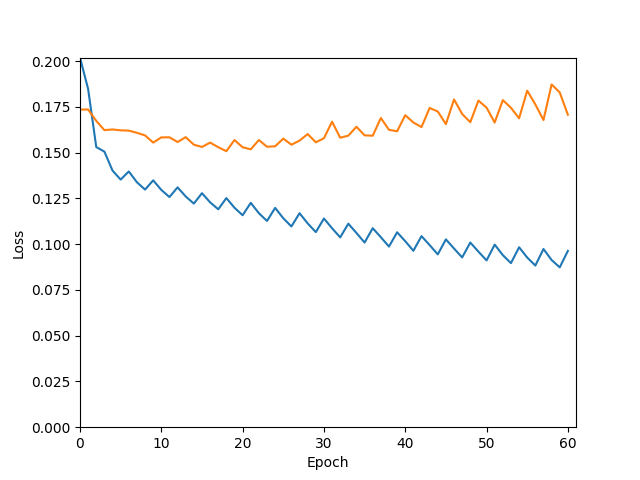

In [7]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import random

zeros_multiplier = 0.25

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

a_files_ids = list(dev_a_files_segments_lim.keys())
a_validation_files_ids = random.sample(a_files_ids, int(len(a_files_ids) * 0.2))
a_train_files_ids = [file_id for file_id in a_files_ids if file_id not in a_validation_files_ids]

a_train_files_segments = {}
b_train_files_segments = {}
c_train_files_segments = {}
for file_id in a_train_files_ids:
    a_train_files_segments[file_id] = dev_a_files_segments_lim[file_id]
    b_train_files_segments[file_id] = dev_b_files_segments_lim[file_id]
    c_train_files_segments[file_id] = dev_c_files_segments_lim[file_id]
a_validation_files_segments = {}
b_validation_files_segments = {}
c_validation_files_segments = {}
for file_id in a_validation_files_ids:
    a_validation_files_segments[file_id] = dev_a_files_segments_lim[file_id]
    b_validation_files_segments[file_id] = dev_b_files_segments_lim[file_id]
    c_validation_files_segments[file_id] = dev_c_files_segments_lim[file_id]

a_train_dataset = Files_dataset(a_train_files_segments, [3],zeros_multiplier = zeros_multiplier)
b_train_dataset = Files_dataset(b_train_files_segments, [5],zeros_multiplier = zeros_multiplier)
c_train_dataset = Files_dataset(c_train_files_segments, [9],zeros_multiplier = zeros_multiplier)
a_train_dataloader = DataLoader(a_train_dataset, batch_size = 32, shuffle = True, num_workers = 8)
b_train_dataloader = DataLoader(b_train_dataset, batch_size = 32, shuffle = True, num_workers = 8)
c_train_dataloader = DataLoader(c_train_dataset, batch_size = 32, shuffle = True, num_workers = 8)

a_validation_dataset = Files_dataset(a_validation_files_segments, [3],zeros_multiplier = zeros_multiplier)
b_validation_dataset = Files_dataset(b_validation_files_segments, [5],zeros_multiplier = zeros_multiplier)
c_validation_dataset = Files_dataset(c_validation_files_segments, [9],zeros_multiplier = zeros_multiplier)
a_validation_dataloader = DataLoader(a_validation_dataset, batch_size = 32, shuffle = True, num_workers = 8)
b_validation_dataloader = DataLoader(b_validation_dataset, batch_size = 32, shuffle = True, num_workers = 8)
c_validation_dataloader = DataLoader(c_validation_dataset, batch_size = 32, shuffle = True, num_workers = 8)

net = Model(dimension, 2).to(device, non_blocking = True)
optimizer = optim.Adam(net.parameters(), lr = 0.0001)

losses = []
with torch.no_grad():
    for dataloader in [a_train_dataloader]:
        for x, y, w in dataloader:
            x = [tensor.to(device, non_blocking = True).float() for tensor in x]
            y = y.to(device, non_blocking = True).float()
            w = w.to(device, non_blocking = True).float()
            criterion = nn.BCELoss(w)
            y_ = net(x)
            loss = criterion(y_, y)
            losses.append(loss.data)
train_loss = (np.sum(losses) / len(losses)).cpu()

train_graph = Train_graph(train_loss)

for epoch in range(20):
    for train_dataloader, validation_dataloader in [(a_train_dataloader, a_validation_dataloader),
                                                (b_train_dataloader, b_validation_dataloader),
                                                (c_train_dataloader, c_validation_dataloader)]:
        losses = []
        for x, y, w in train_dataloader:
            x = [tensor.to(device, non_blocking = True).float() for tensor in x]
            y = y.to(device, non_blocking = True).float()
            w = w.to(device, non_blocking = True).float()

            criterion = nn.BCELoss(w)
            net.zero_grad()
            y_ = net(x)
            loss = criterion(y_, y)
            loss.backward()
            optimizer.step()

            losses.append(loss.data)
        train_loss = np.sum(losses) / len(losses)
        
        validation_losses = []
        with torch.no_grad():
            for x, y, w in validation_dataloader:
                x = [tensor.to(device, non_blocking = True).float() for tensor in x]
                y = y.to(device, non_blocking = True).float()
                w = w.to(device, non_blocking = True).float()
                criterion = nn.BCELoss(w)
                y_ = net(x)
                loss = criterion(y_, y)
                
                validation_losses.append(loss)
        validation_loss = np.sum(validation_losses) / len(validation_losses)
        
        train_graph.draw(train_loss, validation_loss)
        print(train_loss, end = '\r')